## Dask through Jupyter notebooks

This notebook analyzes the output.coffea of the Dask process that is run in Dask_Slurm_Coffea.ipynb.

In [100]:
import coffea
from coffea.hist import plot
import matplotlib.pyplot as plt
import numpy as np
from coffea import hist
import warnings
import mplhep as hep

warnings.filterwarnings('ignore')
plt.rcParams['text.usetex'] = True
#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")

In [101]:
output = coffea.util.load("output.coffea")

### Make some plots from the output file

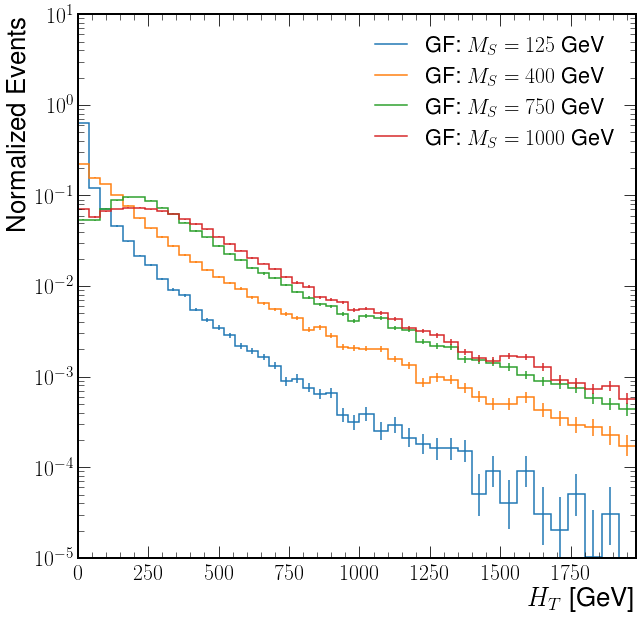

In [102]:
h_ht = output['ht_ak4']

bins = []
bins= np.append(bins, np.arange(0,1000,40))
bins= np.append(bins, np.arange(1000,1500,50))
bins = np.append(bins, np.arange(1500,2000,60))
#print(bins)

h2 = h_ht.rebin("ht_ak4", hist.Bin("ht_ak4", r"$H_T$ [GeV]", bins))

fig = plt.figure()
ax = fig.subplots()
labels = [r"GF: $M_{S}=125$ GeV",r"GF: $M_{S}=400$ GeV",r"GF: $M_{S}=750$ GeV",r"GF: $M_{S}=1000$ GeV"]
plot.plot1d(h2, ax=ax, density=True, 
            order=['M125','M400','M750','M1000'])
_ = ax.set_yscale('log')
_ = ax.set_ylim(1e-5, 1e1)
_ = ax.set_ylabel("Normalized Events")
_ = ax.legend(title=None, labels=labels)
fig.savefig("ht.png")

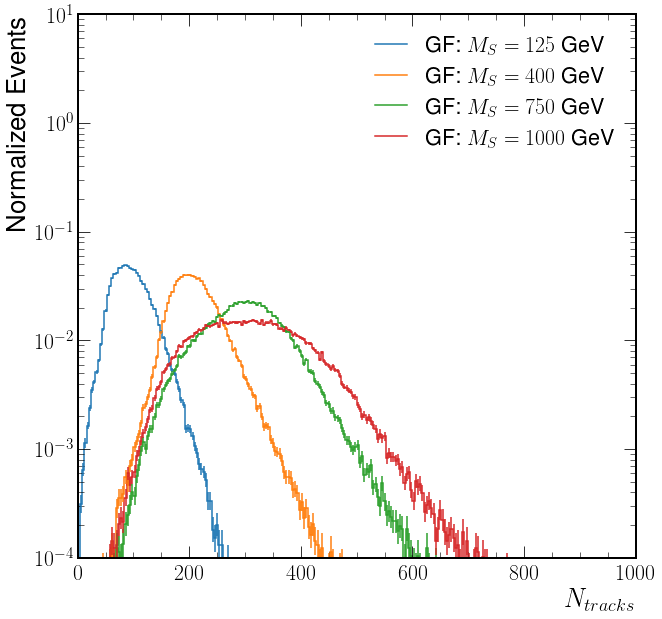

In [103]:
h = output['ntracks']

fig = plt.figure()
ax = fig.subplots()
labels = [r"GF: $M_{S}=125$ GeV",r"GF: $M_{S}=400$ GeV",r"GF: $M_{S}=750$ GeV",r"GF: $M_{S}=1000$ GeV"]
plot.plot1d(h, ax=ax, density=True, 
            order=['M125','M400','M750','M1000'])
_ = ax.set_yscale('log')
_ = ax.set_ylim(1e-4, 1e1)
_ = ax.set_ylabel("Normalized Events")
_ = ax.legend(title=None, labels=labels)
fig.savefig("ntracks.png")

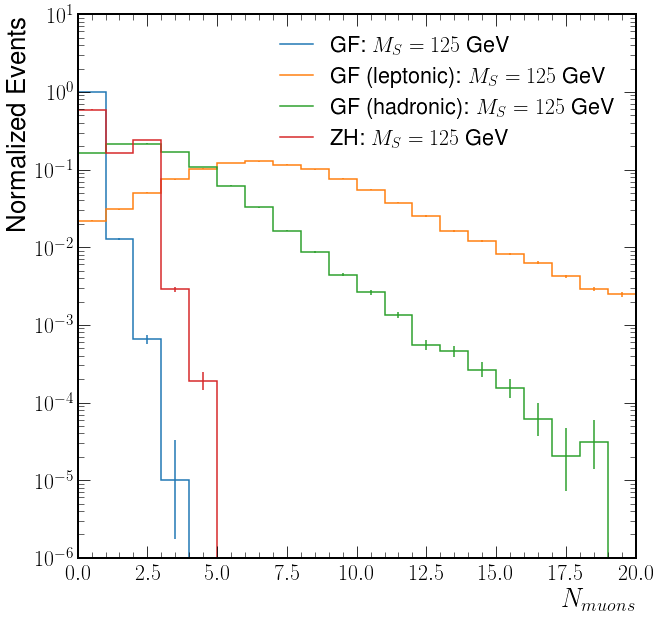

In [91]:
h = output['nmuons']

fig = plt.figure()
ax = fig.subplots()
labels = [r"GF: $M_{S}=125$ GeV",r"GF (leptonic): $M_{S}=125$ GeV",
          r"GF (hadronic): $M_{S}=125$ GeV",r"ZH: $M_{S}=125$ GeV"]
plot.plot1d(h, ax=ax, density=True, 
            order=['ggHpythia_generic_M125_T2genonly','ggHpythia_leptonic_M125_T2genonly',
                   'ggHpythia_hadronic_M125_T2genonly','ZHleptonicpythia_generic_M125_T2genonly'])
_ = ax.set_yscale('log')
_ = ax.set_ylim(1e-6, 1e1)
_ = ax.set_xlim(0,20)
_ = ax.set_ylabel("Normalized Events")
_ = ax.legend(title=None, labels=labels)
fig.savefig("nmuons.png")

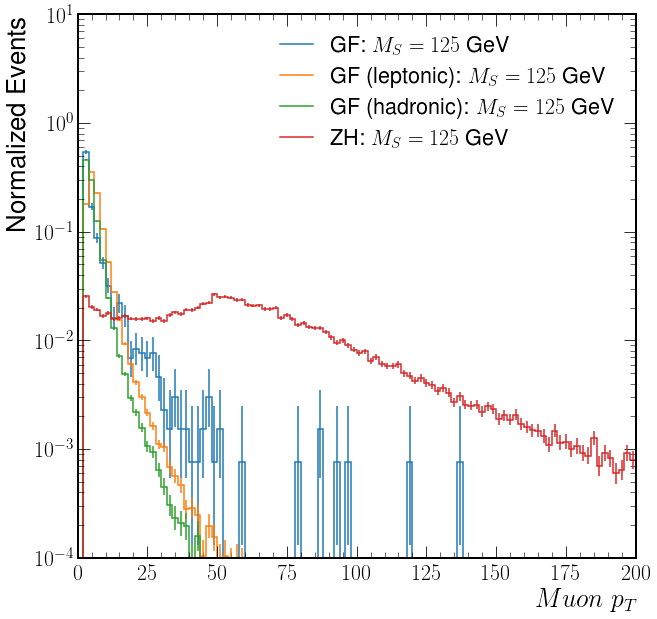

In [98]:
h = output['muon_pt']

fig = plt.figure()
ax = fig.subplots()
labels = [r"GF: $M_{S}=125$ GeV",r"GF (leptonic): $M_{S}=125$ GeV",
          r"GF (hadronic): $M_{S}=125$ GeV",r"ZH: $M_{S}=125$ GeV"]
plot.plot1d(h, ax=ax, density=True, 
            order=['ggHpythia_generic_M125_T2genonly','ggHpythia_leptonic_M125_T2genonly',
                   'ggHpythia_hadronic_M125_T2genonly','ZHleptonicpythia_generic_M125_T2genonly'])
_ = ax.set_yscale('log')
_ = ax.set_ylim(1e-4, 1e1)
_ = ax.set_xlim(0,200)
_ = ax.set_xlabel(r"$Muon~p_T$")
_ = ax.set_ylabel("Normalized Events")
_ = ax.legend(title=None, labels=labels)
fig.savefig("muon_pt.png")

### Calculate yields from the histograms

In [77]:
totals = output['ht_ak4'].integrate("ht_ak4").values(True)
above_1050 = output['ht_ak4'].integrate("ht_ak4", slice(1050,2000)).values(True)
above_500 = output['ht_ak4'].integrate("ht_ak4", slice(500,2000)).values(True)
totals_tracks = output['ntracks'].integrate("ntracks", slice(0,1000)).values(True)
above_100tracks = output['ntracks'].integrate("ntracks", slice(100,1000)).values(True)
totals_comb = output['ntracks_500'].integrate("ntracks_500", slice(0,1000)).values(True)
above20_comb = output['ntracks_500'].integrate("ntracks_500", slice(20,1000)).values(True)
above50_comb = output['ntracks_500'].integrate("ntracks_500", slice(50,1000)).values(True)
above75_comb = output['ntracks_500'].integrate("ntracks_500", slice(75,1000)).values(True)
above100_comb = output['ntracks_500'].integrate("ntracks_500", slice(100,1000)).values(True)
above125_comb = output['ntracks_500'].integrate("ntracks_500", slice(125,1000)).values(True)
above150_comb = output['ntracks_500'].integrate("ntracks_500", slice(150,1000)).values(True)
above200_comb = output['ntracks_500'].integrate("ntracks_500", slice(200,1000)).values(True)

In [78]:
def calc_rates(passing, totals):
    """
    Calculates the yields for certaing events 'passing' a selection, compared to a 'total'.
    
    Input:
    The inputs are expected to be the result of the following acting on a coffea hist:
    passing/totals = hist.integrate("hist_name", slice(x0,x1)).values(True)
    
    Output:
    Returns a dictionary with entried for each SUEP sample and QCD.
    The values are the yield, as well as the plus or minus errors.
    The plus or minus bounds are calculated as:
        numer-unc/denom +unc and numer+unc/denom-unc
    and then are subtracted from the yield to return the uncertainties on the yields.
    """
    
    rates, errs = {}, {}

    
    suep_passing = dict((key[0],value) for key, value in passing.items() if 'QCD' not in key[0])
    qcd_passing = dict((key[0],value) for key, value in passing.items() if 'QCD' in key[0])
    suep_total = dict((key[0],value) for key, value in totals.items() if 'QCD' not in key[0])
    qcd_total = dict((key[0],value) for key, value in totals.items() if 'QCD' in key[0])
        
    for key in list(suep_total.keys()):
        rates.update({key: suep_passing[key][0]/suep_total[key][0]})
        a = suep_passing[key][0]
        b = suep_total[key][0]
        sigma_a = np.sqrt(suep_passing[key][1])
        sigma_b = np.sqrt(suep_total[key][1])
                
        minus = (a-sigma_a) / (b+sigma_b)
        plus = (a+sigma_a) / (b-sigma_b)
        errs.update({key: [plus-a/b, a/b-minus]})
            
    a = np.sum([v[0] for v in qcd_passing.values()])
    b = np.sum([v[0] for v in qcd_total.values()])
    rates.update({'QCD': a/b })
    
    sigma_a = np.sqrt(np.sum([v[1] for v in qcd_passing.values() if v[1] < 1e15]))
    sigma_b = np.sqrt(np.sum([v[1] for v in qcd_total.values() if v[1] < 1e15]))
    minus = (a-sigma_a) / (b+sigma_b)
    plus = (a+sigma_a) / (b-sigma_b)
    errs.update({'QCD': [plus-a/b, a/b-minus]})
    
    return rates, errs

print("above_500", calc_rates(above_500, totals))
#print("above20_comb", calc_rates(above20_comb, totals))
#print("above50_comb", calc_rates(above50_comb, totals))
#print("above75_comb", calc_rates(above75_comb, totals))
#print("above100_comb", calc_rates(above100_comb, totals))
#print("above125_comb", calc_rates(above125_comb, totals))
print("above150_comb", calc_rates(above150_comb, totals))
#print("above200_comb", calc_rates(above200_comb, totals))

above_500 ({'M750': 0.1782306173299008, 'M125': 0.018427779068710157, 'M400': 0.08321073924236852, 'M1000': 0.22466960352422907, 'QCD': nan}, {'M750': [0.0019367679718936825, 0.0019243529205340004], 'M125': [0.0004916154642226785, 0.000488500153349395], 'M400': [0.0011917798549667263, 0.0011841856157936148], 'M1000': [0.002243431427689402, 0.0022291158859639726], 'QCD': [nan, nan]})
above150_comb ({'M750': 0.18107378803386992, 'M125': 0.014416908295531463, 'M400': 0.08428343753831065, 'M1000': 0.22856264726974698, 'QCD': nan}, {'M750': [0.0019567585632372098, 0.001944215368381852], 'M125': [0.0004288328941063884, 0.0004261154291870413], 'M400': [0.001201162401940875, 0.0011935083754626846], 'M1000': [0.002269062079259615, 0.002254582985995457], 'QCD': [nan, nan]})


In [80]:
def make_latex_table(selections, totals):
    """
    Make a latex table using outputs of calc_rates. Samples are mapped to rows.
    
    Input:
    List of output of calc_rates corresponding to the various selections: these are mapped to columns.
    
    Output:
    List of rows of the table as strings.
    """
    
    # dim: selection x sample x rates/errs
    rates, errs = [], []
    for sel in selections: 
        r, e = calc_rates(sel, totals)
        rates.append(r)
        errs.append(e)
        samples = list(r.keys())
            
    table = []
    # rows of table
    for sample in samples:
        if 'QCD' in sample: line =  'QCD & '
        else: line = '$M_{S} = ' + sample[1:] + '$ GeV & '
        
        # columns of table
        for r, e in zip(rates, errs):
        
            if 'QCD' in sample:
                r = str(r[sample])
                plus = str(e[sample][0])
                minus = str(e[sample][1])
                
                r = '$' + r[:3] + '\\times 10^{' + r[-3:] + '}'
                e = '^{+'+ plus[:2] + '\\times 10^{' + plus[-3:] + '}}' + '_{-' + minus[:2] + '\\times 10^{' + minus[-3:] + '}}' + '$ & '
                line += r + e
                
            else:
                line += '$' +  str(round(r[sample],4)) + '^{+'+ str(abs(round(e[sample][0],4))) + '}' + '_{-' + str(abs(round(e[sample][1],3))) + '}' + '$ & '

        line += ' \\\\'
        table.append(line)        
        
    return table
        
table = make_latex_table([above_500, above_1050, above150_comb], totals)
for l in table: print(l)

$M_{S} = 750$ GeV & $0.1782^{+0.0019}_{-0.002}$ & $0.0288^{+0.0006}_{-0.001}$ & $0.1811^{+0.002}_{-0.002}$ &  \\
$M_{S} = 125$ GeV & $0.0184^{+0.0005}_{-0.0}$ & $0.0018^{+0.0001}_{-0.0}$ & $0.0144^{+0.0004}_{-0.0}$ &  \\
$M_{S} = 400$ GeV & $0.0832^{+0.0012}_{-0.001}$ & $0.0124^{+0.0004}_{-0.0}$ & $0.0843^{+0.0012}_{-0.001}$ &  \\
$M_{S} = 1000$ GeV & $0.2247^{+0.0022}_{-0.002}$ & $0.0349^{+0.0007}_{-0.001}$ & $0.2286^{+0.0023}_{-0.002}$ &  \\
QCD & $nan\times 10^{nan}^{+na\times 10^{nan}}_{-na\times 10^{nan}}$ & $nan\times 10^{nan}^{+na\times 10^{nan}}_{-na\times 10^{nan}}$ & $nan\times 10^{nan}^{+na\times 10^{nan}}_{-na\times 10^{nan}}$ &  \\
